In [1]:
import numpy as np
import cv2
import glob
import open3d as o3d
import matplotlib.pyplot as plt

from process_bag import get_images

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# bag_fp = "data/pose/checkerboard.bag"

# color_imgs, depth_imgs = get_images(
#     start_idx=0,
#     end_idx=1000,
#     bag_fp=bag_fp,
#     color_path=None,
#     depth_path=None,
#     align=True,
#     median=False
# )

# idxs = [0, 40, 82, 120, 160, 250, 290, 320, 360, 400, 440]
# for i in idxs:
#     print(i)
#     plt.imshow(color_imgs[i])
#     plt.show()

# color_imgs = color_imgs[idxs]
# depth_imgs = depth_imgs[idxs]
# # Save images
# np.save("data/pose/color.npy", color_imgs)
# np.save("data/pose/depth.npy", depth_imgs)

In [3]:
# Load images
color_imgs = np.load("data/pose/color.npy")
depth_imgs = np.load("data/pose/depth.npy")
color_imgs.shape, depth_imgs.shape

((11, 480, 640, 3), (11, 480, 640))

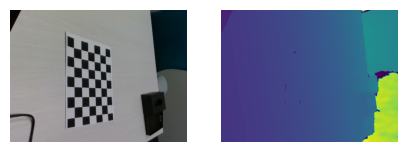

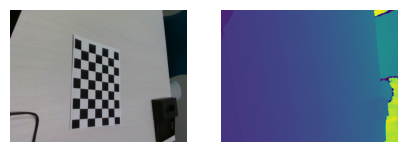

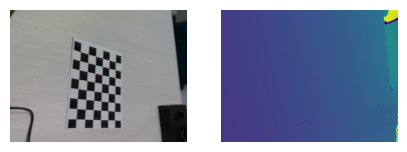

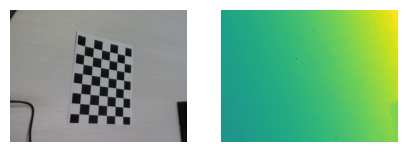

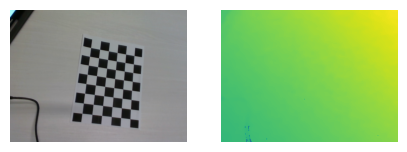

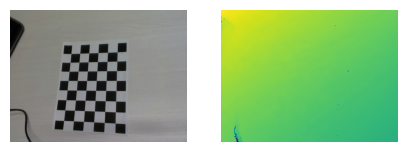

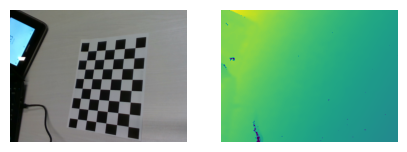

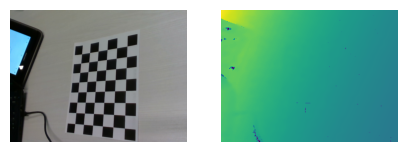

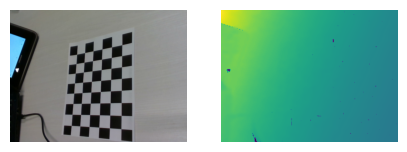

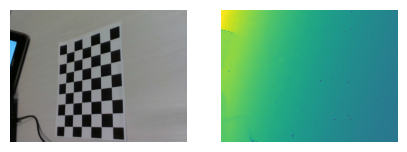

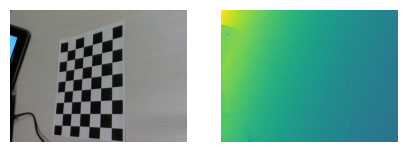

In [4]:
# Plot every frame
for i in range(0, color_imgs.shape[0]):
    fig, ax = plt.subplots(1, 2, figsize=(5, 3))
    ax[0].imshow(color_imgs[i])
    ax[1].imshow(depth_imgs[i])
    ax[0].axis("off")
    ax[1].axis("off")
    plt.show()


In [5]:
# Chessboard size
cb_size = (8, 6)

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points
objp = np.zeros((cb_size[0]*cb_size[1],3), np.float32)
objp[:,:2] = np.mgrid[0:cb_size[0],0:cb_size[1]].T.reshape(-1,2)

# Multiply by square size
# objp *= 0.03

In [6]:
def get_fine_corners(gray, img, corners, plot=False):
    corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)

    # Arrange all corner orders
    if corners2[0, 0, 0] > corners2[-1, 0, 0]:
        corners2 = corners2[::-1]

    # Draw and display the corners
    if plot:
        img_tmp = cv2.drawChessboardCorners(img.copy(), cb_size, corners2,ret)
        plt.imshow(img_tmp)
        plt.show()

    return corners2

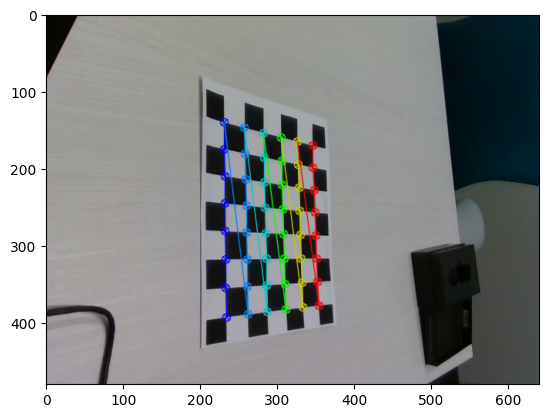

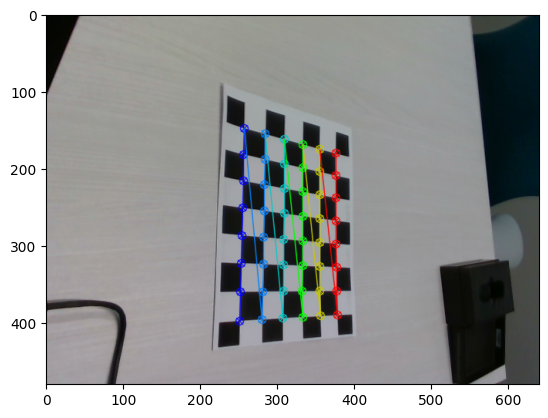

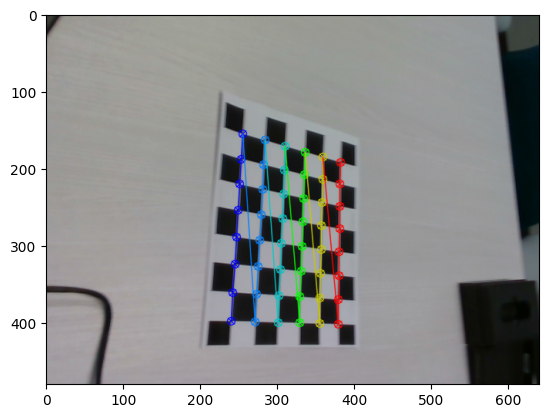

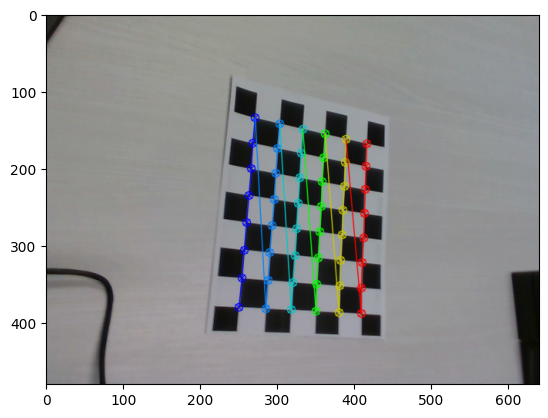

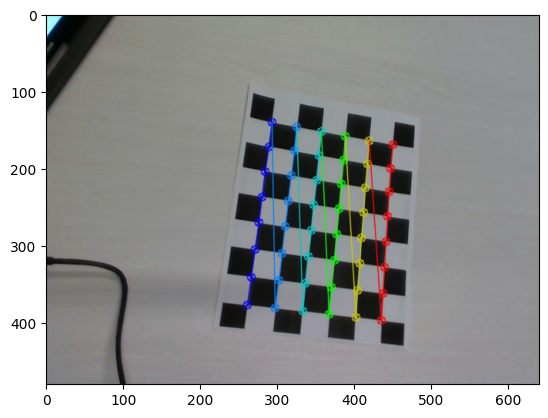

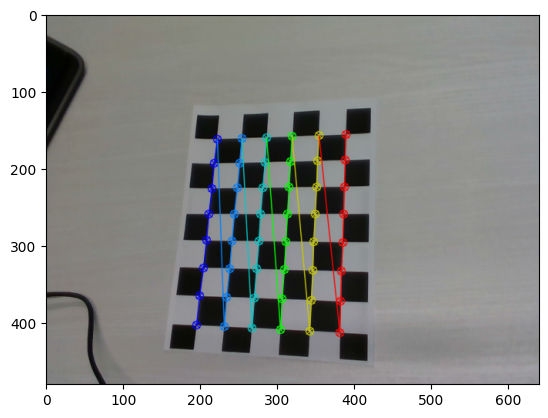

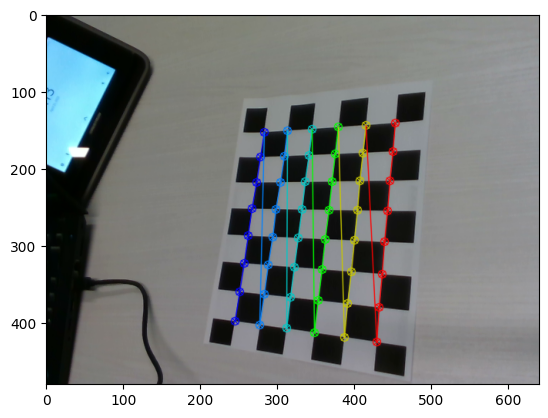

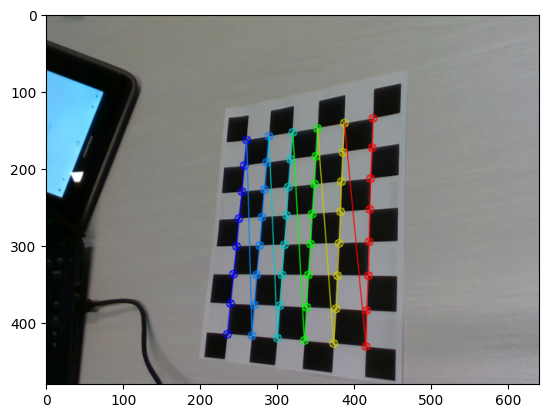

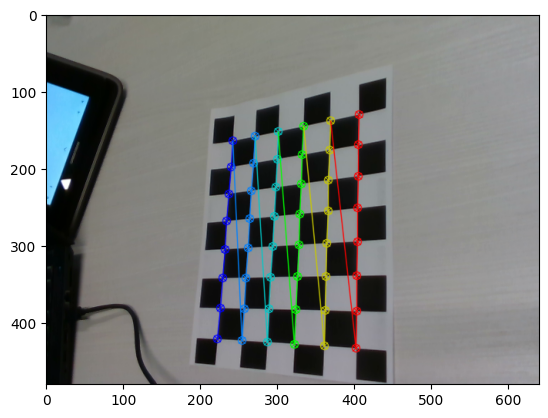

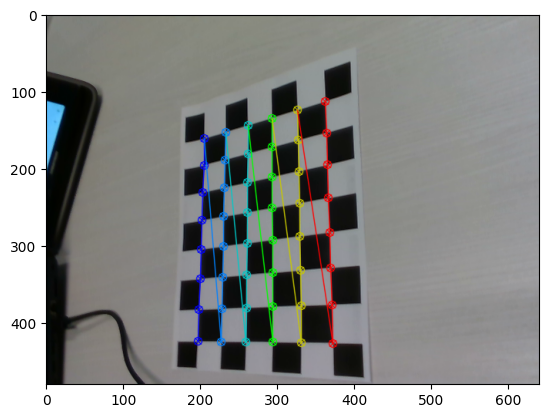

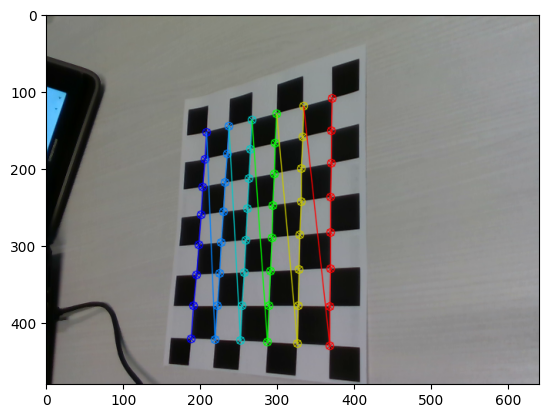

In [7]:
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
used_idxs = []

# Iterate over color_imgs
for i in range(color_imgs.shape[0]):
    img = color_imgs[i]
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, cb_size, None)

    # If found, add object points, image points (after refining them)
    if ret == True:
        used_idxs.append(i)
        objpoints.append(objp)
        imgpoints.append(
            get_fine_corners(gray, img, corners, plot=True)
        )


In [8]:
len(objpoints), len(imgpoints)

(11, 11)

In [9]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
h, w, _ = color_imgs[0].shape
mtx, dist

(array([[614.30372616,   0.        , 323.40619063],
        [  0.        , 613.49095656, 250.28646538],
        [  0.        ,   0.        ,   1.        ]]),
 array([[ 4.61574134e-03,  8.12610265e-01, -3.70086766e-03,
          5.19848121e-04, -3.35376911e+00]]))

In [10]:
# newcameramtx, roi=cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))
# print(roi)
# newcameramtx

# # undistort
# dst = cv2.undistort(img, mtx, dist, None, newcameramtx)

# # crop the image
# x,y,w,h = roi
# dst = dst[y:y+h, x:x+w]
# plt.imshow(dst)
# plt.show()
# plt.imshow(img)
# plt.show()

In [11]:
def draw(img, corners, imgpts):
    corner = tuple(corners[0].ravel())
    # Round all points to int
    corner = (int(corner[0]), int(corner[1]))
    imgpts = np.int32(imgpts).reshape(-1,2)

    img = cv2.line(img, corner, tuple(imgpts[0].ravel()), (255,0,0), 5)
    img = cv2.line(img, corner, tuple(imgpts[1].ravel()), (0,255,0), 5)
    img = cv2.line(img, corner, tuple(imgpts[2].ravel()), (0,0,255), 5)
    return img

0
[[-2.40334213  3.83305532 16.49316693]]


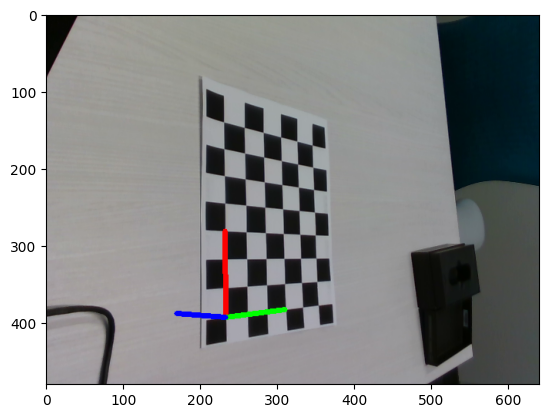

1
[[-1.93403172  3.96960539 16.52097145]]


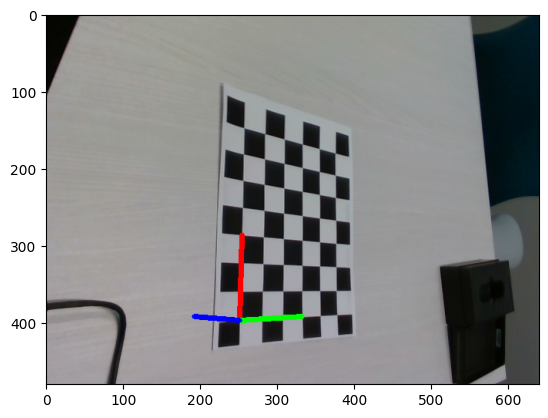

2
[[-2.25779994  4.00424848 16.61422955]]


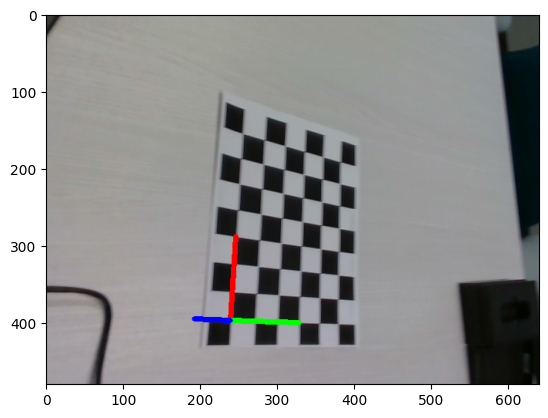

3
[[-1.95374559  3.47683579 16.49000283]]


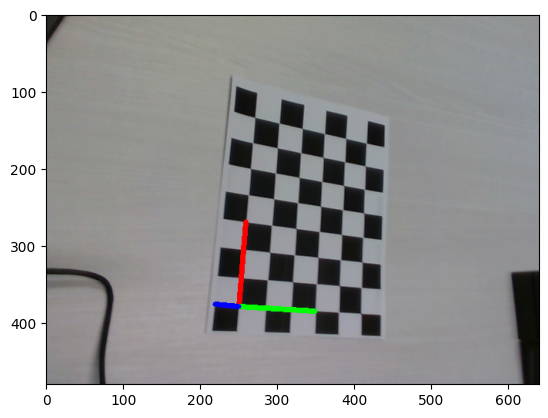

4
[[-1.68644756  3.46910932 16.78156111]]


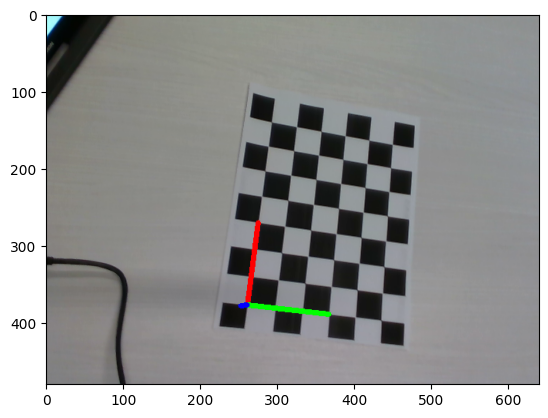

5
[[-3.43044607  4.10310132 16.50504948]]


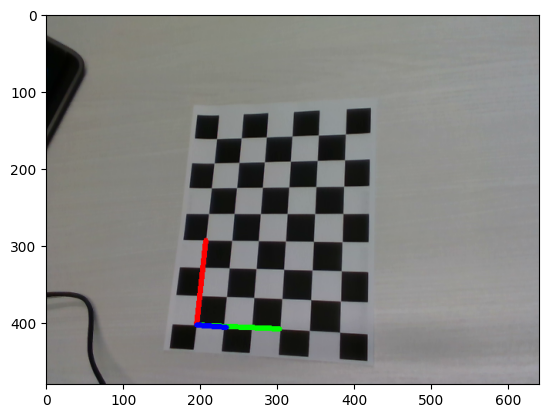

6
[[-2.08372505  3.91291234 16.2565055 ]]


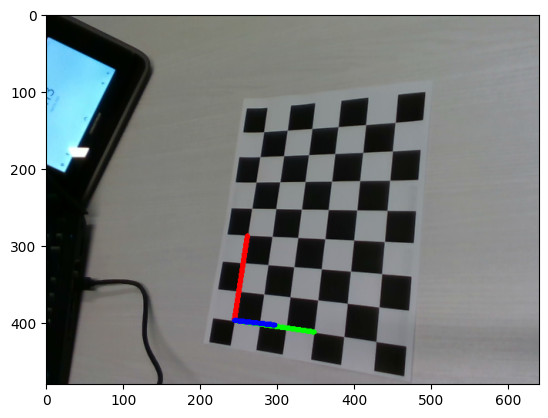

7
[[-2.2887204   4.28084095 16.01033855]]


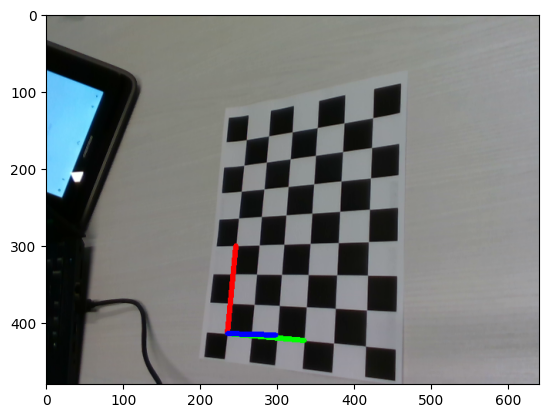

8
[[-2.57371589  4.36492242 15.69617428]]


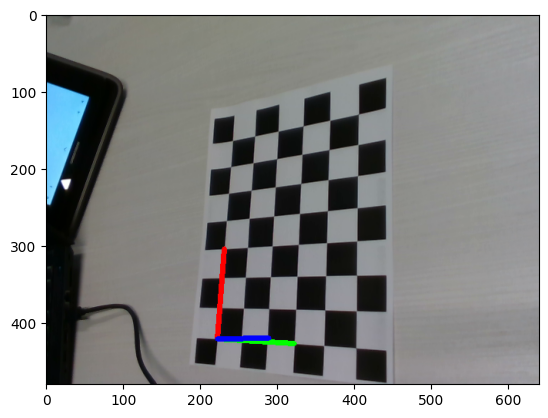

9
[[-3.1466748   4.34297804 15.32768596]]


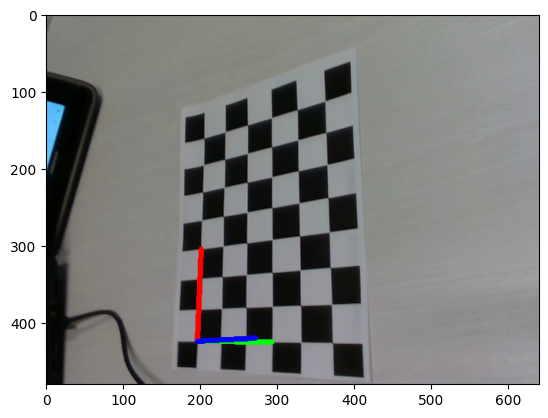

10
[[-3.28894037  4.14864018 15.00416156]]


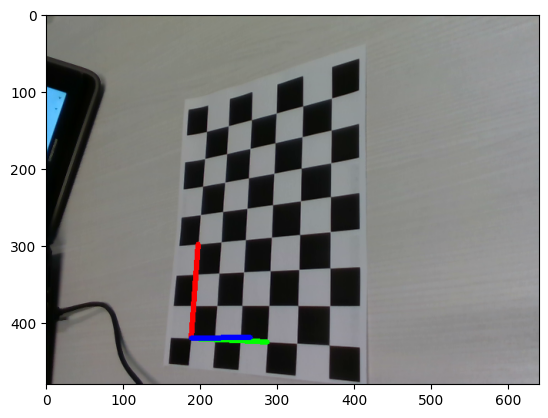

In [12]:
# Note the negative z axis
# axis = np.float32([[3,0,0], [0,3,0], [0,0,-3]]).reshape(-1,3)
axis = np.float32([[3,0,0], [0,3,0], [0,0,3]]).reshape(-1,3)


rvecs_lst = []
tvecs_lst = []
for i in used_idxs:
    print(i)
    img = color_imgs[i]
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, cb_size,None)

    if ret == True:
        corners2 = get_fine_corners(gray, img, corners)

        # Find the rotation and translation vectors.
        retval, rvecs, tvecs, inliers = cv2.solvePnPRansac(
            objp, 
            corners2, 
            mtx, 
            dist,
            iterationsCount=1000,
            reprojectionError=4.0
        )
        print(tvecs.T)

        rvecs_lst.append(rvecs)
        tvecs_lst.append(tvecs)

        # project 3D points to image plane
        imgpts, jac = cv2.projectPoints(axis, rvecs, tvecs, mtx, dist)

        img_tmp = draw(img.copy(),corners2,imgpts)
        plt.imshow(img_tmp)
        plt.show()

In [13]:
# Turn lists into extrinsic parameters
rvecs = np.array(rvecs_lst)
tvecs = np.array(tvecs_lst)

# Turn into 4x4 extrinsic matrices
w2c_exts = np.zeros((len(rvecs), 4, 4))
c2w_exts = np.zeros((len(rvecs), 4, 4))
for i in range(len(rvecs)):
    R, _ = cv2.Rodrigues(rvecs[i])
    w2c_exts[i, :3, :3] = R
    w2c_exts[i, :3, 3] = tvecs[i].T
    w2c_exts[i, 3, 3] = 1

    # world to camera -> camera to world
    c2w_exts[i] = np.linalg.inv(w2c_exts[i])

In [14]:
from utils import get_o3d_intrinsics, colordepth_to_rgbd

depth_intrinsics, color_intrinsics = get_o3d_intrinsics()

In [54]:
# Convert RGBD image to pointcloud
def rgbd_to_pcd(rgbd_image, intrinsics, extrinsics=np.eye(4), voxel_size=None):
    cam = o3d.camera.PinholeCameraParameters()
    cam.intrinsic = intrinsics
    cam.extrinsic = extrinsics

    pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
        rgbd_image, 
        cam.intrinsic, 
        cam.extrinsic
    )

    # Flip it, otherwise the pointcloud will be upside down
    pcd.transform([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])

    # Downsample for speed
    if voxel_size is not None:
        pcd = pcd.voxel_down_sample(voxel_size=voxel_size)
    
    return pcd

In [55]:
# Store in kwargs for easy passing
vis_kwargs = {
    'zoom': 0.3,
    'front': [0,0,-1],
    'lookat': [0,0,0],
    'up': [0,1,0]
}

In [56]:
i = 0
rgbd_img = colordepth_to_rgbd(color_imgs[i], depth_imgs[i])
w2c_ext = w2c_exts[i]
c2w_ext = c2w_exts[i]


In [60]:
voxel_size = 0.002
pcd = rgbd_to_pcd(rgbd_img, color_intrinsics, voxel_size=voxel_size)
# Scale the pointcloud
cb_scale = 0.03
pcd.scale(1/cb_scale, center=[0,0,0])

origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=3, origin=[0,0,0])

# o3d.visualization.draw_geometries([pcd, origin], **vis_kwargs)

In [61]:
camera = o3d.geometry.TriangleMesh.create_coordinate_frame(size=size, origin=[0,0,0])
camera.transform(c2w_ext)


TriangleMesh with 1134 points and 2240 triangles.

In [62]:
pcd.transform(c2w_ext)

o3d.visualization.draw_geometries([pcd, origin, camera])

In [70]:
cb_scale = 0.03
voxel_size = 0.002
size=2

In [71]:
# Draw camera locations and rotations
cameras = []
pcds = []
for i in range(len(color_imgs)):
    # Get the RGBD image
    rgbd_img = colordepth_to_rgbd(color_imgs[i], depth_imgs[i])
    # Get extrinsics
    w2c_ext = w2c_exts[i]
    c2w_ext = c2w_exts[i]
    
    if i == len(color_imgs) - 1:
        size *= 2
    
    # Create a camera frame
    camera = o3d.geometry.TriangleMesh.create_coordinate_frame(size=size, origin=[0,0,0])
    camera.transform(c2w_ext)

    # Create a pointcloud
    pcd = rgbd_to_pcd(rgbd_img, color_intrinsics, voxel_size=voxel_size)
    # Scale the pointcloud
    pcd.scale(1/cb_scale, center=[0,0,0])
    pcd.transform(c2w_ext)

    # Add to lists
    cameras.append(camera)
    pcds.append(pcd)


In [72]:
o3d.visualization.draw_geometries(pcds + [origin] + cameras)

In [34]:
o3d.visualization.draw_geometries([origin] + cameras)

In [20]:
voxel_size = 0.005

pcd = rgbd_to_pcd(
    rgbd_img, 
    intrinsics=color_intrinsics,
    extrinsics=np.eye(4),
    voxel_size=voxel_size
)
pcd.estimate_normals(
    search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))

# Scale inversely by 3cm
pcd.scale(1/0.03, center=pcd.get_center())

# Transform to world coordinates
tmp_extrinsics = extrinsics[6]
# 0 out the translation
tmp_extrinsics[:3, 3] = 0
pcd.transform(tmp_extrinsics)


PointCloud with 14965 points.

In [21]:
# Visualize all
o3d.visualization.draw_geometries([pcd] + cameras + [origin])
